In [1]:
%matplotlib inline

# DCGAN Tutorial

Tutoriel très très fortement instpiré de [dcgan_faces_tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

## Introduction

Ce tutoriel donne une introduction aux DCGANs à travers un exemple. Nous formerons un réseau d'opposition génératif (GAN) pour générer de nouveaux visages après lui avoir montré de nombreuses photos de visages réelles. La plupart du code ici provient de l'implémentation dcgan dans [pytorch/examples](https://github.com/pytorch/examples), et ce document donnera une explication complète de l'implémentation et expliquera comment et pourquoi ce modèle fonctionne.

## Generative Adversarial Networks

### What is a GAN?


Les GANs sont un modèle d'enseignement d'un modèle DL pour capturer la distribution des données d'entraînement afin de pouvoir générer de nouvelles données à partir de cette même distribution. Les GAN ont été inventés par Ian Goodfellow en 2014 et décrits pour la première fois dans le document [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). Ils sont constitués de deux modèles distincts, un *générateur* et un *discriminateur*. Le travail du générateur est de produire de fausses images qui ressemblent aux images d'entraînement. Le travail du discriminateur est de regarder une image et d'afficher s'il s'agit ou non d'une vraie image d'entraînement ou d'une fausse image provenant du générateur. Pendant l'entraînement, le générateur essaie constamment de surpasser le discriminateur en générant de meilleurs faux, tandis que le discriminateur s'efforce de devenir un meilleur détective et de classer correctement les images réelles et fausses. L'équilibre de ce jeu est lorsque le générateur génère des faux parfaits qui semblent provenir directement des données d'entraînement, et que le discriminateur doit toujours deviner à 50% que la sortie du générateur est réelle ou fausse.

Maintenant, définissons une notation à utiliser tout au long du tutoriel en commençant par le discriminateur. Soit $x$ les données représentant une image. $D(x)$ est le réseau de discriminateurs qui fournit la probabilité (scalaire) que $x$ provient des données d'entraînement plutôt que du générateur. Ici, puisqu'il s'agit d'images, l'entrée à $D(x)$ est une image de taille RGB 3x64x64x64. Intuitivement, $D(x)$ devrait être ÉLEVÉ lorsque $x$ provient des données de formation et BAS lorsque $x$ provient du générateur. $D(x)$ peut aussi être considéré comme un classificateur binaire traditionnel.

Pour la notation du générateur, supposons que $z$ soit un vecteur d'espace latent échantillonné à partir d'une distribution normale standard. $G(z)$ représente la fonction générateur qui mappe le vecteur latent $z$ à l'espace de données. L'objectif de $G$ est d'estimer la distribution d'où proviennent les données de formation ($p_{data}$) pour pouvoir générer de faux échantillons à partir de cette distribution estimée ($p_g$).

Ainsi, $D(G(z))$ est la probabilité (scalaire) que la sortie du générateur $G$ est une image réelle. Comme décrit dans [l'article de Goodfellow](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), $D$ et $G$ jouent à un jeu minimax dans lequel $D$ tente de maximiser la probabilité qu'il classifie correctement les réels et les faux ($logD(x)$), et $G$ tente de minimiser la probabilité que $D$ prévoie que ses résultats soient faux ($log(1-D(G(x))$)). A partir du papier, la fonction de perte GAN est la suivante

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

En théorie, la solution à ce jeu minimax est où $p_g = p_{data}$, et le discriminateur devine au hasard si les entrées sont réelles ou fausses. Cependant, la théorie de la convergence des GANs fait encore l'objet de recherches actives et, en réalité, les modèles ne s'entraînent pas toujours à ce point.

### What is a DCGAN?

Un DCGAN est une extension directe du GAN décrit ci-dessus, sauf qu'il utilise explicitement des couches convolutives et convolutives-transpositives dans le discriminateur et le générateur, respectivement. Elle a été décrite pour la première fois par Radford et al. dans le document [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf). Le discriminateur est composé de couches strided [convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d), de couches [batch norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) et de couches [LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activations. L'entrée est une image d'entrée 3x64x64 et la sortie est une probabilité scalaire que l'entrée provient de la distribution réelle des données. Le générateur est composé de couches [convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d), de couches de normes de lot et d'activations [ReLU](https://pytorch.org/docs/stable/nn.html#relu). L'entrée est un vecteur latent, $z$, qui est tiré d'une distribution normale standard et la sortie est une image RGB 3x64x64. Les couches conv-transposées en strided permettent de transformer le vecteur latent en un volume ayant la même forme qu'une image. Dans cet article, les auteurs donnent également quelques conseils sur la façon de configurer les optimiseurs, de calculer les fonctions de perte et d'initialiser les poids du modèle, qui seront tous expliqués dans les prochaines sections.

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs

Définissons quelques entrées pour le run :

In [3]:
dataroot = 'images/CFD_Images' # Répertoire racine pour l'ensemble de données
workers = 2 # Nombre de travailleurs pour dataloader

batch_size = 9  # Taille des lot pendant l'entraînement
image_size = 64 # Taille spatiale des images d'entraînement.
                #     Toutes les images seront redimensionnées comme suit en utilisant un transformateur.
                #     Cette implémentation par défaut est 64x64.
                #     Si une autre taille est souhaitée,  les structures de D et G doivent être modifiées.
                #     Voir [ici](https://github.com/pytorch/examples/issues/70)

nc = 3   # Nombre de canaux dans les images d'entraînement. (3 pour les images en couleur)
nz = 100 # Taille du vecteur latent z (c.-à-d. taille de l'entrée du générateur)
ngf = 64 # Taille des cartes d'entités dans le générateur
ndf = 64 # Taille des cartes d'entités dans le discriminateur

num_epochs = 15 # Nombre d'époques d'entraînement à exécuter.
                # Un entraînement plus longtemps conduira probablement à de meilleurs résultats,
                # mais prendra aussi beaucoup plus de temps

lr = 0.0002     # Taux d'apprentissage des optimiseurs
beta1 = 0.5     # Beta1 hyperparamètre pour les optimiseurs Adam
ngpu = 1        # Nombre de GPU disponibles. Utilisez 0 pour le mode CPU.

## Data

Dans ce tutoriel, nous utiliserons le jeu de données [Chicago Face Database](https://chicagofaces.org/default/). le dossier *CFD_Images* devra être placé dans dossier *images*. La structure de répertoire résultante devrait être :

    /images/CFD_Images
       -> AF-200
           -> CFD-AF-200-228-N.jpg
       -> AF-201
           -> CFD-AF-201-060-N.jpg
          ...

Nous utiliserons la classe d'ensemble de données ImageFolder, qui nécessite qu'il y ait des sous-répertoires dans le dossier racine de l'ensemble de données.

In [4]:
# Nous pouvons utiliser un ensemble de données de dossier d'image de la façon dont nous l'avons configuré.

# Transformation à faire sur les image d'entraînement
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# Créez l'ensemble de données
import torchvision.datasets as dset
dataset = dset.ImageFolder(root=dataroot, transform=transform)

# Créez le dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Décidez sur quel appareil nous voulons tourner
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

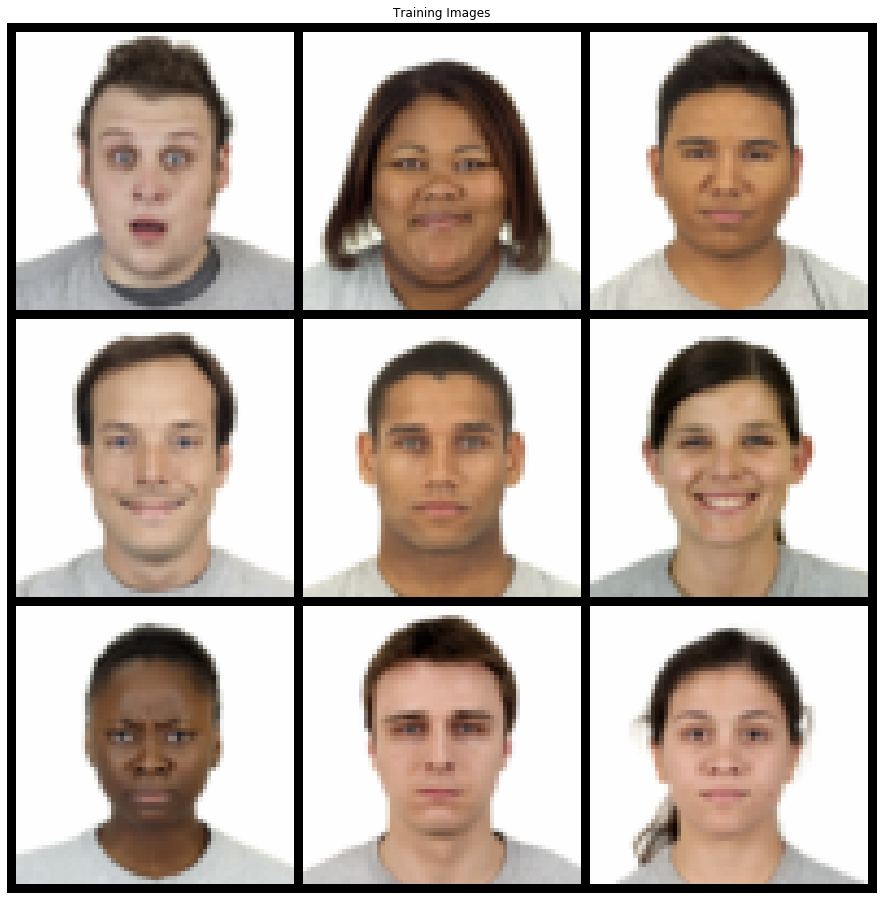

In [5]:
# Afficher des images d'entraînement

real_batch = next(iter(dataloader))
# real_batch[0] -> images d'un lot d'entrainement
# real_batch[1] -> classes des images d'un lot d'entraînement


import torchvision.utils as vutils
# on fabrique une grille des images
grid_images = vutils.make_grid(real_batch[0].to(device), padding=2, nrow=3, normalize=True).cpu()
images = np.transpose(grid_images, (1,2,0)) # permet de réarranger grid_images pour pouvoir l'afficher


plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(images);

## Implementation

Avec nos paramètres d'entrée et l'ensemble de données préparé, nous pouvons maintenant passer à l'implementation.

### Initialisation du poids


D'après l'article du DCGAN, les auteurs précisent que tous les poids du modèle doivent être initialisés de façon aléatoire à partir d'une distribution normale avec moyenne=0, stdev=0,02. La fonction ``weights_init`` prend un modèle initialisé en entrée et réinitialise toutes les couches de normalisation convolutive, convolutive-transposition et batch pour répondre à ce critère. Cette fonction est appliquée aux modèles immédiatement après l'initialisation.

In [6]:
# Initialisation de poids personnalisés appelés sur netG et netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator


Le générateur, $G$, est conçu pour mapper le vecteur d'espace latent ($z$) dans l'espace de données. Puisque nos données sont des images, convertir $z$ en espace de données signifie finalement créer une image RVB de la même taille que les images d'entraînement (i.e. 3x64x64x64). Dans la pratique, cela se fait par une série de couches convolutionnelles bidimensionnelles transposées, chacune couplée à une couche de batch norm 2d et à une activation relu. La sortie du générateur est alimentée par une fonction tanh pour revenir à la plage de données d'entrée de $[-1,1]$. Il convient de noter l'existence des fonctions de batch norm après les couches conv-transpose, car il s'agit d'une contribution essentielle du document DCGAN. Ces couches aident à l'écoulement des gradients pendant l'entraînement. Une image du générateur tirée de l'article de DCGAN est montrée ci-dessous.

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="900"/>

Notez comment les entrées que nous avons définies dans la section d'entrée (*nz*, *ngf*, et *nc*) influencent l'architecture du générateur en code.
- **nz** est la longueur du vecteur d'entrée z,
- **ngf** se rapporte à la taille des cartes de caractéristiques qui sont propagées par le générateur,
- **nc** est le nombre de canaux dans l'image de sortie (défini à 3 pour les images RGB).

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # entrée est Z, entrant dans une convolution
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # taille des états (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # taille des états (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # taille des états (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # taille des états(ngf) x 32 x 32
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # taille des états (nc) x 64 x 64
        
        )

    def forward(self, input):
        return self.main(input)

### Discriminator

Comme nous l'avons mentionné, le discriminateur $D$ est un réseau de classification binaire qui prend une image en entrée et émet une probabilité scalaire que l'image entrée est réelle (par opposition à fausse). Ici, $D$ prend une image d'entrée 3x64x64, la traite à travers une série de couches Conv2d, BatchNorm2d, et LeakyReLU, et affiche la probabilité finale par une fonction d'activation Sigmoid. Cette architecture peut être étendue avec d'autres couches si nécessaire pour le problème, mais l'utilisation de la convolution stridée, BatchNorm et LeakyReLU est importante. Le document du DCGAN mentionne que c'est une bonne pratique d'utiliser la convolution stridée plutôt que la mise en commun pour réduire l'échantillon parce qu'elle permet au réseau d'apprendre sa propre fonction de mise en commun. De plus, la norme de lot et les fonctions de résistance aux fuites favorisent un gradient d'écoulement sain, ce qui est essentiel pour le processus d'apprentissage des $G$ et des $D$.

In [8]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # entrée est (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf) x 32 x 32
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf*8) x 4 x 4
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Maintenant, nous pouvons instancier le générateur et le discriminateur et appliquer la fonction ``weights_init``. Vérifiez le modèle retourné pour voir comment les objets générateur et discriminateur sont structuré.

In [9]:
# Créez le générateur
netG = Generator(ngpu).to(device)

# Créer le discriminateur
netD = Discriminator(ngpu).to(device)


# Manipulez le multi-gpu si vous le souhaitez
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Appliquer la fonction weights_init pour initialiser aléatoirement tous les poids pour mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

# Afficher les modèles
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Loss Functions and Optimizers

Avec la configuration $D$ et $G$, nous pouvons spécifier comment ils apprennent à travers les fonctions de perte et les optimiseurs. Nous utiliserons la fonction de perte d'entropie binaire ([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss) qui est définie dans PyTorch comme :

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notez comment cette fonction fournit le calcul des deux composantes log dans la fonction objectif (c'est-à-dire $log(D(x))$ et $log(1-D(G(z)))$). Nous pouvons spécifier quelle partie de l'équation de BCE utiliser avec l'entrée $y$. Ceci est accompli dans la boucle de formation qui s'ouvre bientôt, mais il est important de comprendre comment nous pouvons choisir le composant que nous voulons calculer en changeant simplement $y$ (i.e. les étiquettes GT).

Ensuite, nous définissons notre étiquette réelle comme 1 et la fausse étiquette comme 0, qui sera utilisée pour calculer les pertes de $D$ et $G$, et c'est aussi la convention utilisée dans le papier GAN original. Enfin, nous avons mis en place deux optimiseurs distincts, l'un pour $D$ et l'autre pour $G$. Tel que spécifié dans le document du DCGAN, les deux sont des optimiseurs d'Adam avec un taux d'apprentissage de 0,0002 et Beta1 = 0,5. Pour suivre la progression d'apprentissage du générateur, nous allons générer un lot fixe de vecteurs latents qui sont tirés d'une distribution gaussienne (i.e. fixed_noise) . Dans la boucle d'apprentissage, nous entrerons périodiquement ce bruit_fixe dans $G$, et au cours des itérations, nous verrons des images se former à partir du bruit.

In [10]:
# Initialiser la fonction BCELoss
criterion = nn.BCELoss()

# Créer un lot de vecteurs latents que nous utiliserons pour visualiser la progression du générateur
fixed_noise = torch.randn(9, nz, 1, 1, device=device)

# Établir une convention pour les vraies et fausses étiquettes pendant la formation
real_label = 1
fake_label = 0

# Configurez les optimiseurs Adam pour G et D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Enfin, maintenant que nous avons défini toutes les parties du cadre du GAN, nous pouvons le former. Gardez à l'esprit que l'entraînement au GAN est une forme d'art, car des paramètres hyperparamétriques incorrects entraînent l'effondrement du mode sans que l'on sache vraiment ce qui s'est mal passé. Ici, nous suivrons de près l'algorithme 1 de l'article de Goodfellow, tout en respectant certaines des meilleures pratiques présentées dans [ganhacks](https://github.com/soumith/ganhacks). A savoir, nous allons "construire différents mini-batchs pour des images réelles et fausses", et aussi ajuster la fonction objectif de G pour maximiser $logD(G(z))$. La formation est divisée en deux parties principales. La partie 1 met à jour le Discriminator et la partie 2 met à jour le Generator.

**Part 1 - Entraînement Discriminator**

Rappelons que l'objectif de l'entraînement du discriminateur est de maximiser la probabilité de classer correctement un intrant donné comme réel ou faux. En ce qui concerne Goodfellow, nous souhaitons "mettre à jour le discriminateur en augmentant son gradient stochastique". Concrètement, nous voulons maximiser $log(D(x)) + log(1-D(G(z)))$. En raison de la suggestion de mini-lots séparée des ganhacks, nous allons calculer cela en deux étapes. Tout d'abord, nous allons construire un lot d'échantillons réels à partir de l'ensemble de formation, passer par $D$, calculer la perte ($log(D(x))$), puis calculer les gradients dans une passe en arrière. Deuxièmement, nous allons construire un lot de faux échantillons avec le générateur actuel, passer ce lot par $D$, calculer la perte ($log(1-D(G(z)))$), et *accumuler* les gradients avec une passe en arrière. Maintenant, avec les gradients accumulés à partir des lots tout réel et tout faux, nous appelons une étape de l'optimiseur du Discriminator.


**Part 2 - Entraînement Generator**

Comme indiqué dans le document original, nous voulons former le Générateur en minimisant $log(1-D(G(z)))$ dans un effort pour générer de meilleurs faux. Comme nous l'avons mentionné, Goodfellow a montré que cela ne permettait pas d'obtenir des gradients suffisants, surtout au début du processus d'apprentissage. En guise de correctif, nous souhaitons plutôt maximiser $log(D(G(z)))$. Dans le code, nous accomplissons ceci en classifiant la sortie du Générateur de la Partie 1 avec le Discriminator, en calculant la perte de G *en utilisant des étiquettes réelles comme GT*, en calculant les gradients de G dans une passe en arrière, et finalement en mettant à jour les paramètres de G avec une étape d'optimisation. Il peut sembler contre-intuitif d'utiliser les étiquettes réelles comme étiquettes GT pour la fonction de perte, mais cela nous permet d'utiliser la partie $log(x)$ du BCELoss (plutôt que la partie $log(1-x)$) qui est exactement ce que nous voulons.

Enfin, nous ferons quelques rapports statistiques et à la fin de chaque époque, nous pousserons notre lot de bruit fixe à travers le générateur pour suivre visuellement la progression de la formation de G. Les statistiques de formation rapportées le sont :

- **Loss_D** - perte de discriminateur calculée comme la somme des pertes pour tous les lots réels et tous les faux lots ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - perte du générateur calculée en $log(D(G(z)))$.
- **D(x)** - la sortie moyenne (sur l'ensemble du lot) du discriminateur pour le lot réel. Ceci devrait commencer près de 1 puis théoriquement converger vers 0,5 lorsque G s'améliorera. Réfléchissez à la raison pour laquelle c'est comme ça.
- **D(G(z))** - sorties moyennes du discriminateur pour le lot tout faux. Le premier chiffre est avant que D ne soit mis à jour et le deuxième chiffre est après que D soit mis à jour. Ces nombres devraient commencer près de 0 et converger vers 0,5 à mesure que G s'améliore. Réfléchissez à la raison pour laquelle c'est comme ça.

**Remarque:** Cette étape peut prendre un certain temps, selon le nombre d'époques que vous exécutez.

In [11]:
# Boucle d'entraînement

# Listes pour suivre l'avancement des projets
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Pour chaque époque
for epoch in range(num_epochs):
    # Pour chaque lot dans le dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Mise à jour du réseau D : maximiser log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Entraînement avec des lots réels
        netD.zero_grad()
        # Format lot
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Transfére le lot réel dans D
        output = netD(real_cpu).view(-1)
        # Calcule la perte sur les lots réels
        errD_real = criterion(output, label)
        # Calcule les gradients pour D en pas en arrière.
        errD_real.backward()
        D_x = output.mean().item()

        ## Entraînement avec des lots faux
        # Génére un lot de vecteurs latents
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Génére un lot de fausses images avec G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classe tous les faux lots avec D
        output = netD(fake.detach()).view(-1)
        # Calcule la perte de D sur le lot faux.
        errD_fake = criterion(output, label)
        # Calcule les gradients pour ce lot
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Ajoute les gradients des lots réel et faux.
        errD = errD_real + errD_fake
        # Mise à jour D
        optimizerD.step()

        ############################
        # (2) Mise à jour du réseau G : maximiser log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # les fausses étiquettes sont réelles pour le coût du générateur
        # Puisque nous venons de mettre à jour D, effectuons une autre passe en avant du lot faux à travers D
        output = netD(fake).view(-1)
        # Calculez la perte de G à partir de ce résultat.
        errG = criterion(output, label)
        # Calculer les gradients pour G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Mise à jour G
        optimizerG.step()
        
        # Statistiques d'entraînement en sortie
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Enregistrer les pertes pour les tracer plus tard
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Vérifier l'état du générateur en sauvegardant la sortie de G sur le bruit_fixe.
        if (iters % 135 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            #print(iters, epoch, i)
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, nrow=3, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/15][0/135]	Loss_D: 1.5022	Loss_G: 8.1728	D(x): 0.6675	D(G(z)): 0.5712 / 0.0007
[0/15][50/135]	Loss_D: 0.0172	Loss_G: 9.2912	D(x): 0.9918	D(G(z)): 0.0087 / 0.0001
[0/15][100/135]	Loss_D: 0.0012	Loss_G: 33.6803	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[1/15][0/135]	Loss_D: 0.2421	Loss_G: 32.2008	D(x): 0.8705	D(G(z)): 0.0000 / 0.0000
[1/15][50/135]	Loss_D: 0.0003	Loss_G: 26.8307	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[1/15][100/135]	Loss_D: 0.4792	Loss_G: 7.4230	D(x): 0.9999	D(G(z)): 0.2355 / 0.0013
[2/15][0/135]	Loss_D: 0.4437	Loss_G: 7.8059	D(x): 0.9725	D(G(z)): 0.2760 / 0.0007
[2/15][50/135]	Loss_D: 0.3970	Loss_G: 4.5671	D(x): 0.9482	D(G(z)): 0.2488 / 0.0147
[2/15][100/135]	Loss_D: 0.2853	Loss_G: 2.2303	D(x): 0.8275	D(G(z)): 0.0624 / 0.1382
[3/15][0/135]	Loss_D: 0.6241	Loss_G: 6.0159	D(x): 0.9915	D(G(z)): 0.4079 / 0.0035
[3/15][50/135]	Loss_D: 0.2251	Loss_G: 2.9017	D(x): 0.9857	D(G(z)): 0.1776 / 0.0693
[3/15][100/135]	Loss_D: 0.7040	Loss_G: 5.6170	D(x): 0.8681	

## Résultats

### Loss versus training iteration

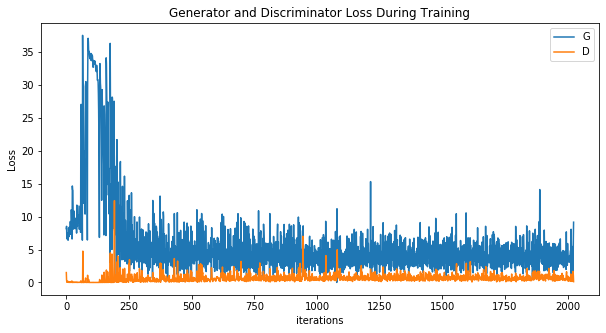

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization of G’s progression

Rappelez-vous comment nous avons sauvegardé la sortie du générateur sur le lot de bruit fixe après chaque époque de formation. Maintenant, nous pouvons visualiser la progression de l'entraînement de G avec une animation. Appuyez sur le bouton de lecture pour démarrer l'animation.

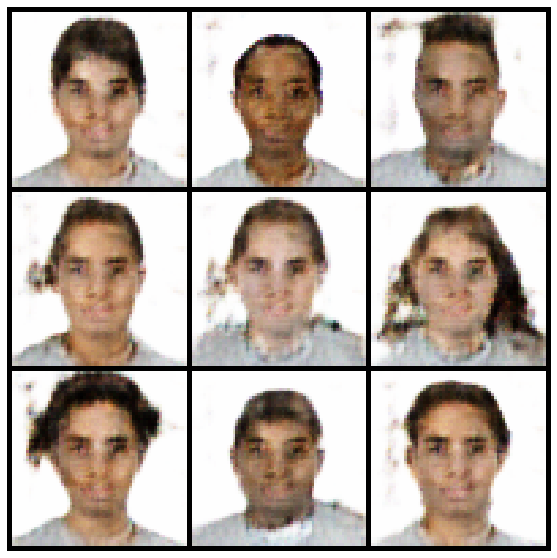

In [13]:
#%%capture
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Real Images vs. Fake Images

Enfin, jetons un coup d'oeil à de vraies images et à de fausses images côte à côte.

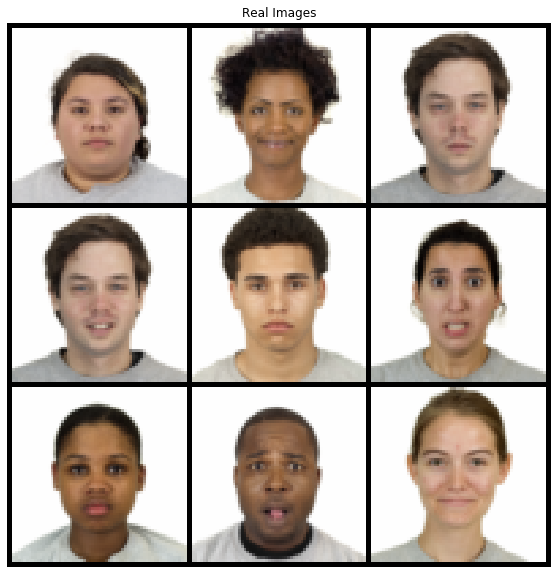

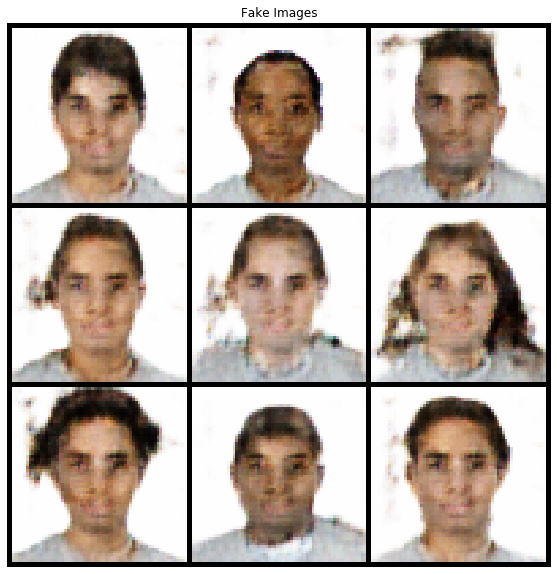

In [14]:
# Récupérer un lot d'images réelles du dataloader
real_batch = next(iter(dataloader))

# Tracez les images réelles
plt.figure(figsize=(10,10))
#plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), nrow=3, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Tracez les fausses images de la dernière époque
plt.figure(figsize=(10,10))
#plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Oú aller ensuite


Nous sommes arrivés à la fin de notre voyage, mais il y a plusieurs endroits où vous pouvez aller à partir d'ici. Vous pourriez :

- S'entraîner plus longtemps pour voir à quel point les résultats sont bons
- Modifier ce modèle pour prendre un ensemble de données différent et éventuellement modifier la taille des images et l'architecture du modèle.
- Jetez un coup d'œil à d'autres projets GAN sympas [ici](https://github.com/nashory/gans-awesome-applications)
- Créer des GANs qui génèrent de la [musique](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)